In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Carrega dados
df = pd.read_excel('data.xlsx')
df.head()


,mês,Cartões,Conta,Convênios e Pagamentos,Canais de Relacionamento,Empréstimo e Financiamento,Recuperação de Crédito,Investimentos,Institucional,Seguros,Cheques,Crédito Rotativo,Consórcios,Previdência,NPS
0,janeiro,74,62,57,48,41,36,20,18,13,6,6,2,2,66
1,fevereiro,70,60,55,49,39,37,17,15,13,11,8,2,2,72
2,março,92,79,72,70,50,41,41,19,19,9,4,3,3,66
3,abril,74,70,59,38,36,25,25,13,12,9,6,3,3,63
4,maio,98,82,65,50,48,36,29,17,13,9,6,4,4,63


In [3]:
# Converte NPS para variável binária para regressão logística
# NPS > 70 para promotores (1) e <= 50 para detratores (0)

df['NPS_binario'] = (df['NPS'] > 70).astype(int)

In [4]:
# Categorias de Reclamações
categ_reclamacoes = ['Cartões', 'Conta', 'Convênios e Pagamentos', 'Canais de Relacionamento',
                        'Empréstimo e Financiamento', 'Recuperação de Crédito', 'Investimentos',
                        'Institucional', 'Seguros', 'Cheques', 'Crédito Rotativo', 'Consórcios',
                        'Previdência']

In [5]:
# Teste ADF: avalia se medidas de tendência central são constantes no decorrer do tempo (estacionárias), critério para aplicar o teste de Granger

teste_adf = {}

for categoria in categ_reclamacoes:
    adf_test = adfuller(df[categoria])
    teste_adf[categoria] = {'ADF Statistic': adf_test[0], 'p-value': adf_test[1]}

In [6]:
df_teste_adf = pd.DataFrame(teste_adf).T
df_teste_adf.head(10)

,ADF Statistic,p-value
Cartões,-2.424287,1.349986e-01
Conta,-1.918820,3.232599e-01
Convênios e Pagamentos,-2.050936,2.646951e-01
Canais de Relacionamento,-9.704718,1.049341e-16
Empréstimo e Financiamento,-12.598763,1.754995e-23
Recuperação de Crédito,-3.028416,3.232460e-02
Investimentos,-1.294787,6.315537e-01
Institucional,0.704276,9.899228e-01
Seguros,0.089562,9.653412e-01
Cheques,-2.248439,1.891366e-01


Canais de Relacionamento, Empréstimo e Financiamento e Recuperação de Crédito apresentam valor p < 0.05, o que afirma que estas duas variáveis são estacionárias 
O df deveria ser tratado para a análise

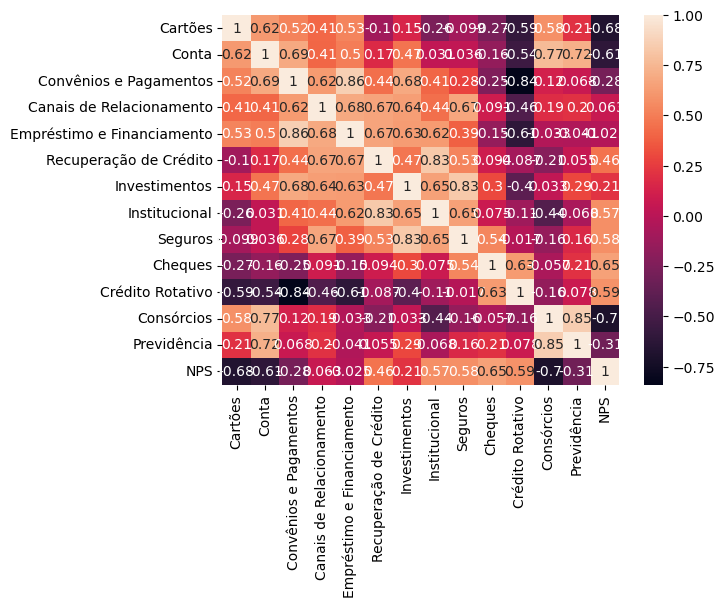

In [7]:
# Matriz de Correlação
matriz_correlacao = df[categ_reclamacoes + ['NPS']].corr()

sns.heatmap(matriz_correlacao, annot=True)
plt.show()


# Análise Causal

In [8]:
# Teste de Granges: verifica se os valores passados das categorias de reclamação tem significância estatística na queda do NPS
# Usado em séries temporais para avaliar se uma variável pode predizer a outra
# Não implica relação de causa e efeito
# Obs.: a maioria das variáveis não são estacionárias, o que é um problema para o teste

from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 1

categ_influenciam = []

for categoria in categ_reclamacoes:
    if len(df[[categoria, 'NPS']].dropna()) > 3 * max_lag:
        resultado_teste = grangercausalitytests(df[[categoria, 'NPS']], max_lag, verbose=False)
        p_values = [round(resultado_teste[i+1][0]['ssr_chi2test'][1], 4) for i in range(max_lag)]
        min_p_value = min(p_values)
        if min_p_value < 0.05:
            categ_influenciam.append((categoria, min_p_value))
        
print('As categorias que possivelmente impactam no NPS são:', categ_influenciam)

As categorias que possivelmente impactam no NPS são: [('Recuperação de Crédito', 0.0395), ('Investimentos', 0.0008), ('Institucional', 0.0), ('Seguros', 0.0), ('Cheques', 0.0)]


### Resultado
- As categorias que possivelmente impactam no NPS são: [('Recuperação de Crédito', 0.0395), ('Investimentos', 0.0008), ('Institucional', 0.0), ('Seguros', 0.0), ('Cheques', 0.0)]

Os valores p < 0.05 indicam a probabilidade da relação entre as variáveis não ser ao acaso.

O teste de Granger avalia causalidade temporal. Como nossa amostra é muito pequena e os dados aleatórios, o teste não deve ser considerado válido.



# Regrassão Logística

In [9]:
df.head()

,mês,Cartões,Conta,Convênios e Pagamentos,Canais de Relacionamento,Empréstimo e Financiamento,Recuperação de Crédito,Investimentos,Institucional,Seguros,Cheques,Crédito Rotativo,Consórcios,Previdência,NPS,NPS_binario
0,janeiro,74,62,57,48,41,36,20,18,13,6,6,2,2,66,0
1,fevereiro,70,60,55,49,39,37,17,15,13,11,8,2,2,72,1
2,março,92,79,72,70,50,41,41,19,19,9,4,3,3,66,0
3,abril,74,70,59,38,36,25,25,13,12,9,6,3,3,63,0
4,maio,98,82,65,50,48,36,29,17,13,9,6,4,4,63,0


In [11]:
# Separa entre variáveis dependentes(targuet) e independentes(preditoras)
preditoras = df[categ_reclamacoes]
target = df['NPS_binario']

# Separa em treino e teste
X_train, X_test, y_train, y_test = train_test_split(preditoras, target, test_size=0.3)

# treina o modelo
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# predições
predictions = modelo.predict(X_test)

# probabilidades
prob_predictions = modelo.predict_proba(X_test)

c:\Users\f0014938\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\f0014938\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\f0014938\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [12]:
predictions, prob_predictions

(array([0, 1, 0]),
 array([[9.99852595e-01, 1.47404523e-04],
        [1.64186437e-01, 8.35813563e-01],
        [9.98304399e-01, 1.69560053e-03]]))

In [13]:
# Métricas de avaliação

print('classification report')
print(classification_report(y_test, predictions))
print('confusion matrix')
print(confusion_matrix(y_test, predictions))


classification report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3

confusion matrix
[[2 1]
 [0 0]]


c:\Users\f0014938\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\f0014938\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\f0014938\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
